In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import silhouette_score
from kneed import KneeLocator
import seaborn as sns
import warnings

warnings.filterwarnings("ignore")
sns.set(style="whitegrid")


In [2]:
# Load Data
df = pd.read_csv("Final.csv") 

print("\nPreview of data:")
display(df.head())



Preview of data:


,Country,Region,Date,AQI,Temperature,RelativeHumidity,WindSpeed
0,Malaysia,AlorSetar,2014-01-01,34.0,26.11,76.95,21.52
1,Malaysia,AlorSetar,2014-01-02,30.0,26.48,77.45,20.62
2,Malaysia,AlorSetar,2014-01-03,28.0,26.40,78.64,17.37
3,Malaysia,AlorSetar,2014-01-04,32.0,26.38,79.88,15.41
4,Malaysia,AlorSetar,2014-01-05,37.0,26.32,77.90,14.90


In [3]:
#Data Cleaning
print("\nMissing values before cleaning:\n", df.isnull().sum())

# Convert to numeric where needed
for col in ['AQI', 'Temperature', 'RelativeHumidity', 'WindSpeed']:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Fill AQI missing with mean
df['AQI'] = df['AQI'].fillna(df['AQI'].mean())

print("\nMissing values after cleaning:\n", df.isnull().sum())



Missing values before cleaning:
 Country             0
Region              0
Date                0
AQI                 0
Temperature         0
RelativeHumidity    0
WindSpeed           0
dtype: int64

Missing values after cleaning:
 Country             0
Region              0
Date                0
AQI                 0
Temperature         0
RelativeHumidity    0
WindSpeed           0
dtype: int64



Clustering for: Malaysia


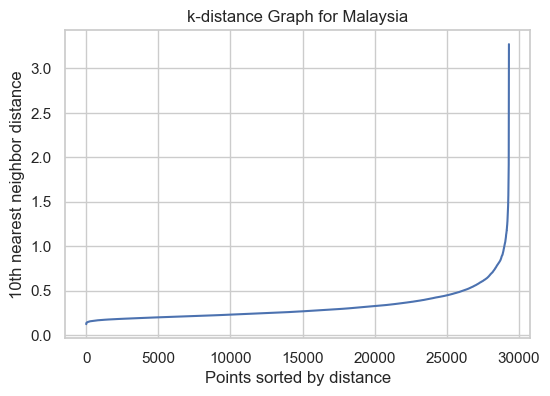

Suggested eps: 1.274070523084707

Cluster counts:
Cluster
 0    29299
-1        9
 2        4
 1        4
Name: count, dtype: int64

Average values per cluster:
                AQI  Temperature  RelativeHumidity  WindSpeed
Cluster                                                      
-1       112.111111    27.213333         79.802222  22.543333
 0        43.338677    26.535900         85.044195  11.546688
 1       213.750000    28.085000         78.492500  11.110000
 2       236.000000    26.697500         87.187500  10.617500
Silhouette Score: 0.66
Number of noise points: 9


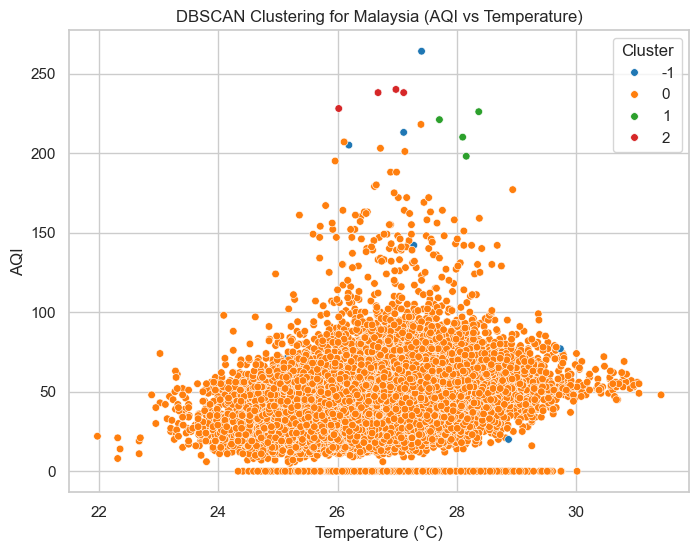


Clustering for: Singapore


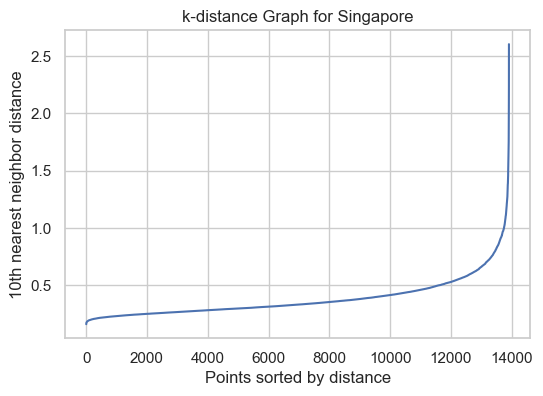

Suggested eps: 0.9931606178183656

Cluster counts:
Cluster
 0    13893
-1       15
Name: count, dtype: int64

Average values per cluster:
               AQI  Temperature  RelativeHumidity  WindSpeed
Cluster                                                     
-1       40.186667    27.926000         77.353333   9.490000
 0       46.963675    28.045162         79.528437   5.116261
Silhouette Score: 0.52
Number of noise points: 15


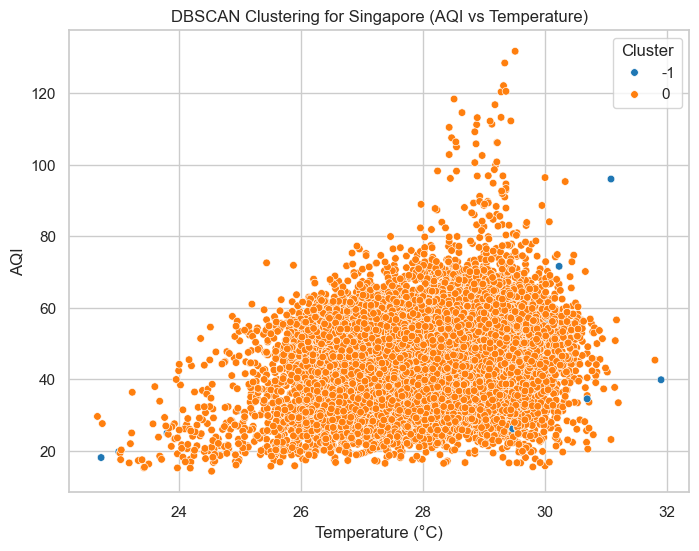


Clustering for: Thailand


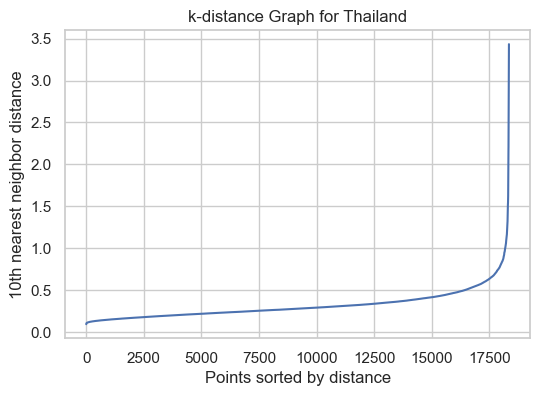

Suggested eps: 0.9477255560512572

Cluster counts:
Cluster
 0    18309
-1       48
Name: count, dtype: int64

Average values per cluster:
                AQI  Temperature  RelativeHumidity  WindSpeed
Cluster                                                      
-1       242.022083    22.376250         63.789583  11.671250
 0       131.987500    27.299106         74.964836   8.400993
Silhouette Score: 0.52
Number of noise points: 48


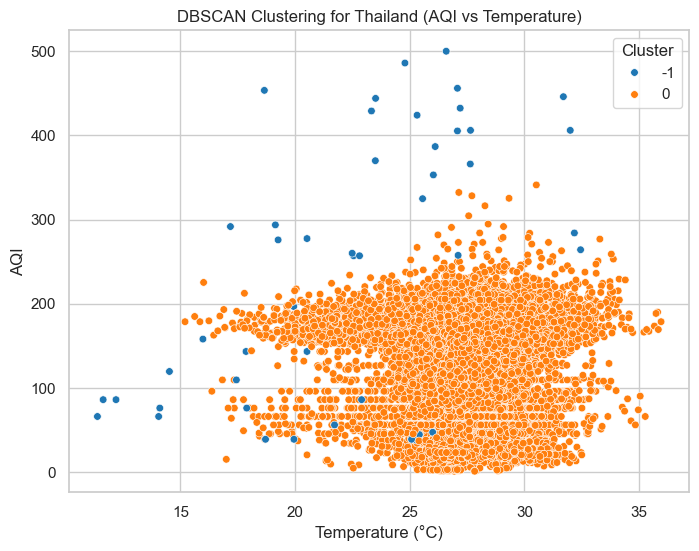

In [5]:
#DBSCAN 
all_results = []  # Store all country results

for country, group in df.groupby("Country"):
    print(f"\n============================")
    print(f"Clustering for: {country}")
    print("============================")

    # Clean and ensure numeric
    for col in ['AQI', 'Temperature', 'RelativeHumidity', 'WindSpeed']:
        group[col] = pd.to_numeric(group[col], errors='coerce')

    group = group.dropna(subset=['AQI', 'Temperature', 'RelativeHumidity', 'WindSpeed'])

    # Select features (added Month and Season)
    X = group[['AQI', 'Temperature', 'RelativeHumidity', 'WindSpeed']].values

    # Normalize
    X_scaled = StandardScaler().fit_transform(X)


    # Find k-distance plot (for visual)
    neigh = NearestNeighbors(n_neighbors=10)
    nbrs = neigh.fit(X_scaled)
    distances, indices = nbrs.kneighbors(X_scaled)
    distances = np.sort(distances[:, -1])

    plt.figure(figsize=(6, 4))
    plt.plot(distances)
    plt.title(f"k-distance Graph for {country}")
    plt.xlabel("Points sorted by distance")
    plt.ylabel("10th nearest neighbor distance")
    plt.grid(True)
    plt.show()


    knee = KneeLocator(range(len(distances)), distances, curve='convex', direction='increasing')
    eps_value = distances[knee.knee]
    print("Suggested eps:", eps_value)

    # Apply DBSCAN (you can tweak eps per country if needed)
    db = DBSCAN(eps=eps_value, min_samples=4)
    group['Cluster'] = db.fit_predict(X_scaled)

    # Show results
    print("\nCluster counts:")
    print(group['Cluster'].value_counts())

    print("\nAverage values per cluster:")
    print(group.groupby('Cluster')[['AQI', 'Temperature', 'RelativeHumidity', 'WindSpeed']].mean())

    labels = db.labels_
    # Evaluate clustering using Silhouette score
    silhouette_avg = silhouette_score(X_scaled, labels)

    print(f'Silhouette Score: {silhouette_avg:.2f}')

    # Identifying noise points (labeled as -1)
    n_noise = np.sum(labels == -1)
    print(f'Number of noise points: {n_noise}')

    # Visualize clusters (AQI vs Temperature)
    plt.figure(figsize=(8, 6))
    sns.scatterplot(data=group, x='Temperature', y='AQI', hue='Cluster', palette='tab10', s=30)
    plt.title(f"DBSCAN Clustering for {country} (AQI vs Temperature)")
    plt.xlabel("Temperature (°C)")
    plt.ylabel("AQI")
    plt.legend(title="Cluster")
    plt.show()

    